In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from scipy.stats import wasserstein_distance

import time

from torch.utils.data import DataLoader, TensorDataset

## Dataset

California Housing Price, from the UCI Machine Learning repository
The dataset contains information from the 1990 California census.
There are 10 features, 1 of them is categorical variable while the rest are numerical variables.

https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [2]:
# Read the CSV file
housing_data = pd.read_csv("housing.csv")

# Check for missing values
missing_values = housing_data.isnull().sum()

# Display missing values
print("Missing Values:")
print(missing_values)

Missing Values:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [3]:
# Optional: Percentage of missing values
total_cells = housing_data.size
total_missing = missing_values.sum()
percentage_missing = (total_missing / total_cells) * 100
print(f"\nPercentage of missing values: {percentage_missing:.2f}%")


Percentage of missing values: 0.10%


In [4]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


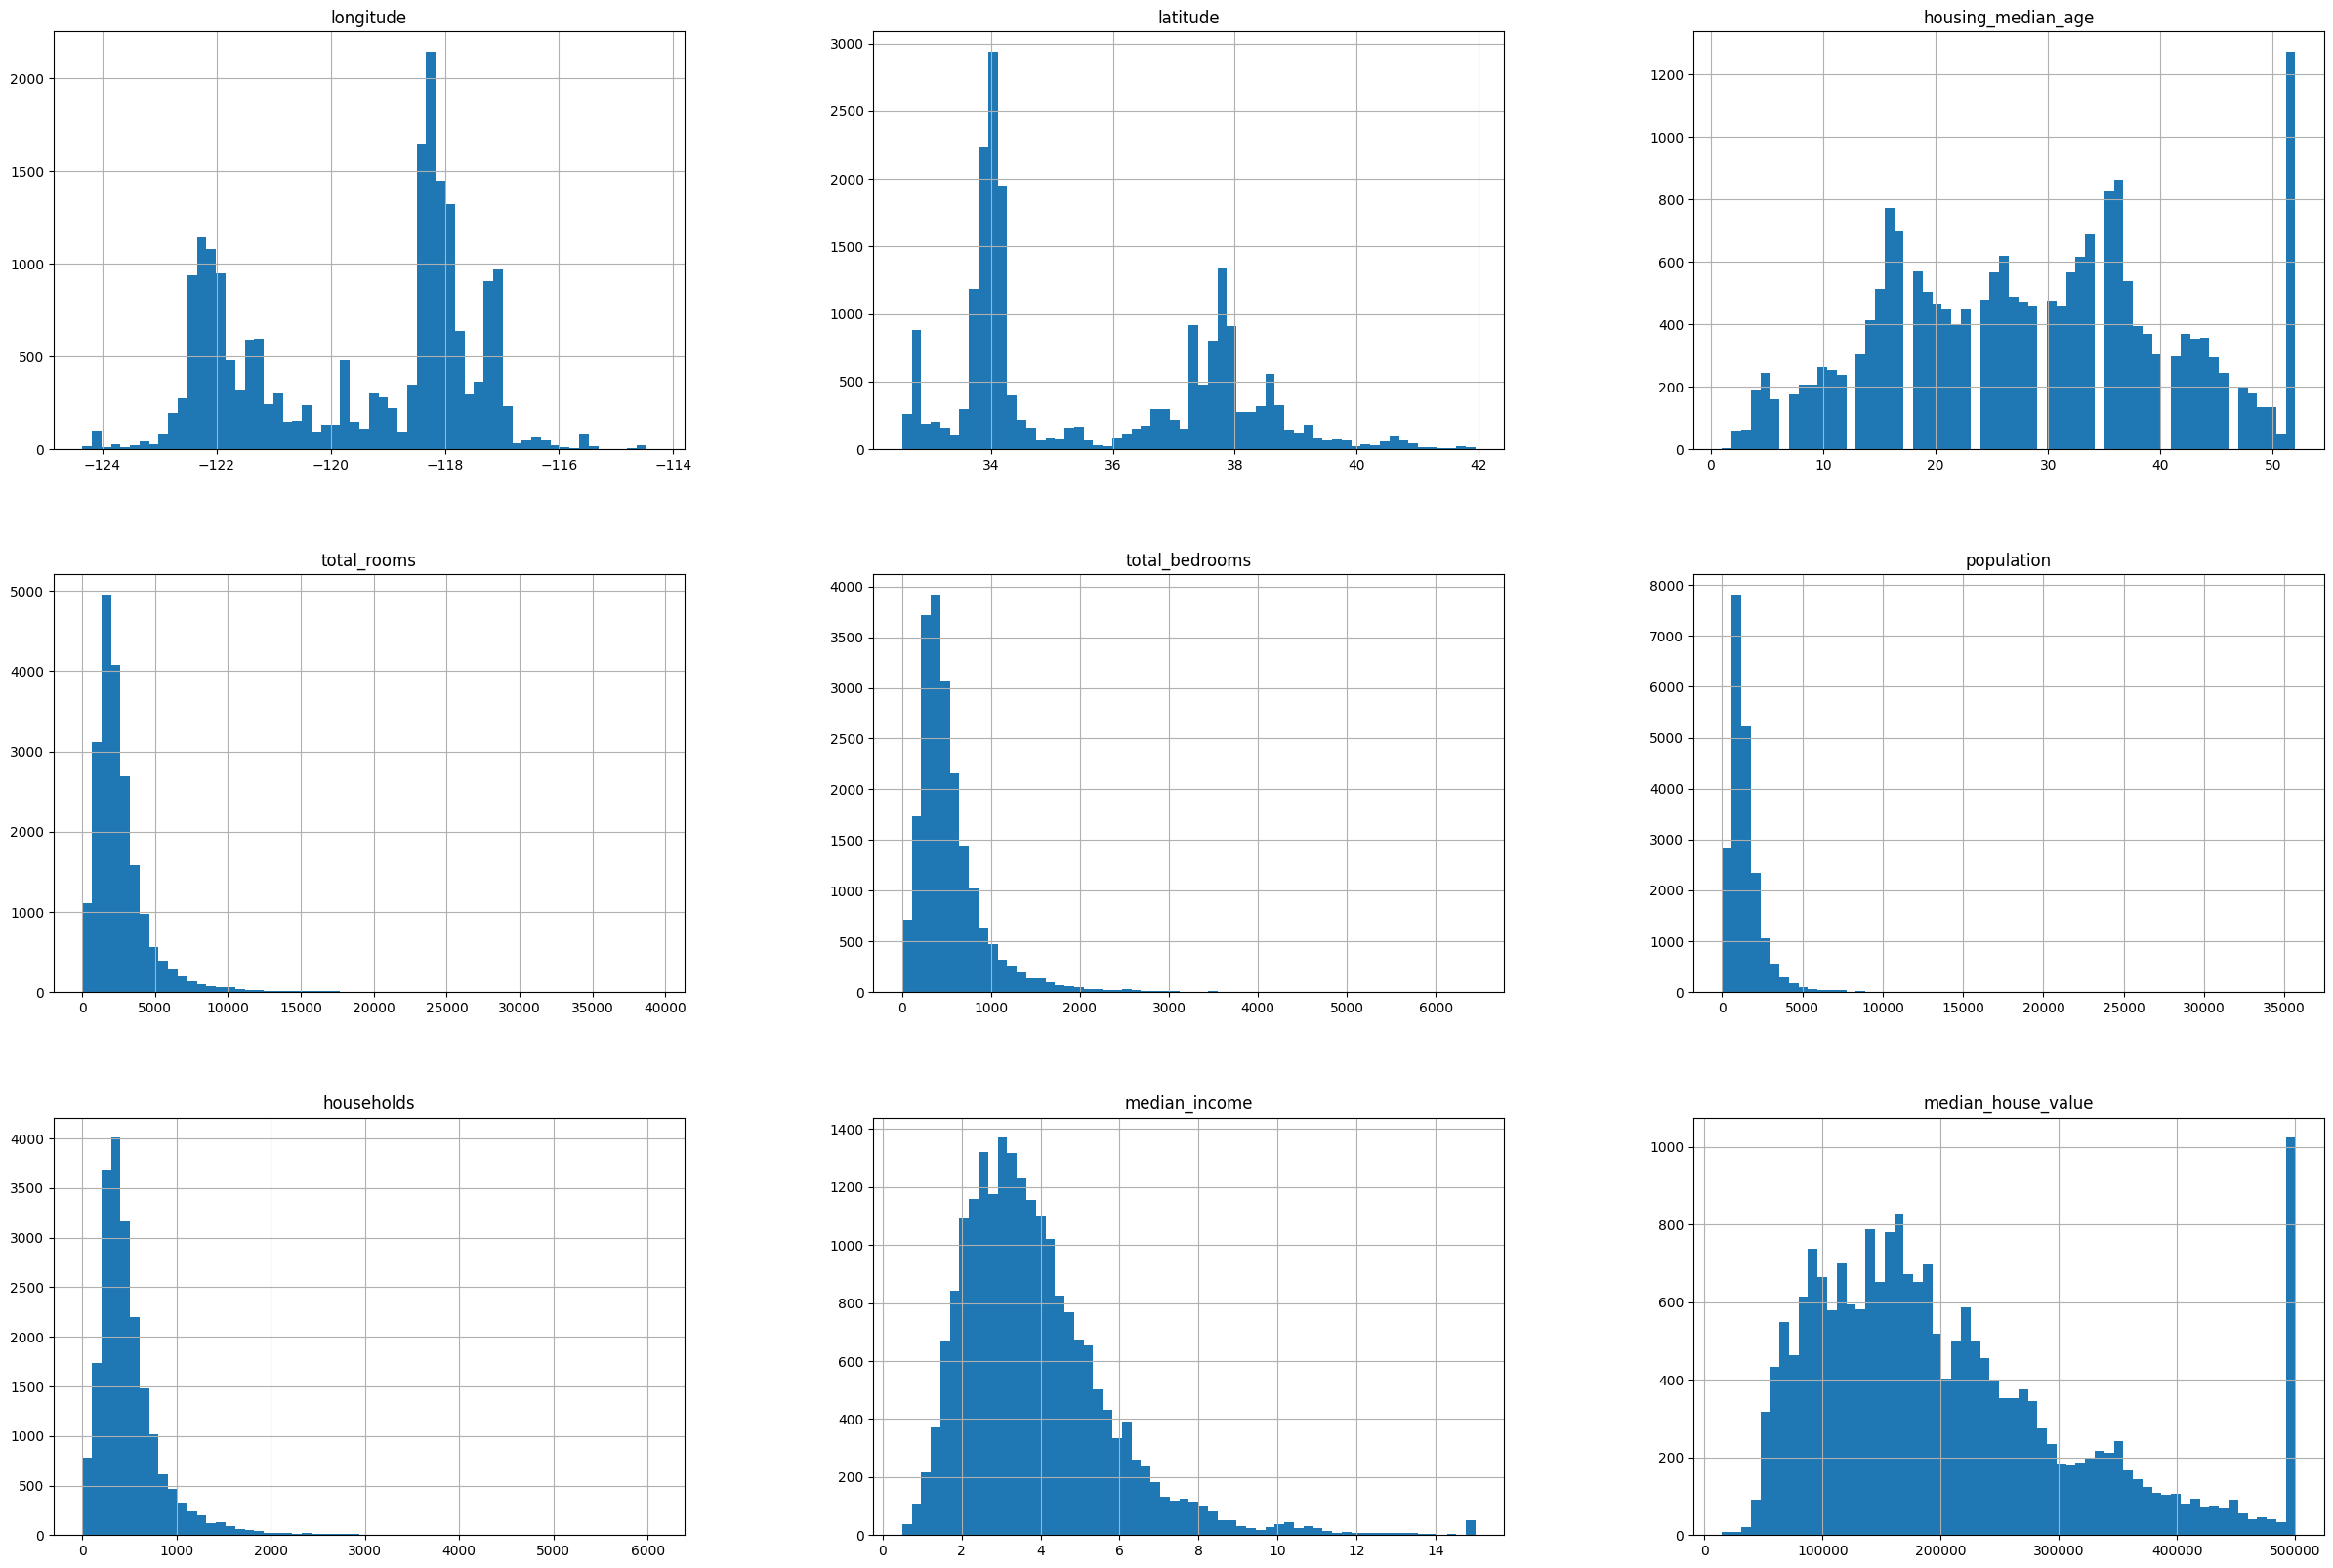

In [5]:
#Understanding the features of dataframe by plotting plots.
housing_data.hist(bins = 60, figsize = (30,20))
plt.show()

In [6]:
housing_data['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

## Preprocessing

using one hot encoder, min max scaler transform, manually masking out some values to 80% data presence

In [7]:
housing_data = pd.read_csv("housing.csv")
housing_data = housing_data.dropna()

housing_cat = housing_data[["ocean_proximity"]]
encoder = OneHotEncoder(sparse=False)
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_encoded = pd.DataFrame(housing_cat_encoded, columns=encoder.get_feature_names_out(['ocean_proximity']))
housing_encoded.index = housing_data.index
housing_data = pd.concat([housing_data, housing_encoded], axis=1).drop('ocean_proximity', axis=1)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(housing_data.values)
data_scaled = scaler.transform(data_scaled)

data_scaled = torch.tensor(data_scaled, dtype=torch.float32)

train_scaled, test_scaled = train_test_split(data_scaled, test_size=0.2, random_state=42)

# Mask the data: 0 where data is missing
mask_train = torch.bernoulli(torch.full((train_scaled.shape[0], train_scaled.shape[1]), 0.8))  # 80% data presence
train_input = train_scaled * mask_train

mask_test = torch.bernoulli(torch.full((test_scaled.shape[0], test_scaled.shape[1]), 0.8))  # 80% data presence
test_input = test_scaled * mask_test

train_dataset = TensorDataset(train_input, train_scaled) 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(test_input, test_scaled)
test_loader = DataLoader(test_dataset, batch_size=32)

/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Models

In [8]:
class HyperImpute(nn.Module):
    def __init__(self, input_dim):
        super(HyperImpute, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, input_dim)  # Predict the original input_dim
        )

    def forward(self, x):
        return self.network(x)

In [9]:
# Model definition using Transformer
class MAETransformerModel(nn.Module):
    def __init__(self, num_features, masking_ratio=0.75, d_model=128, dropout=0.1, nhead=4, dim_feedforward=2048, num_layers=2):
        super(MAETransformerModel, self).__init__()

        self.masking_ratio = masking_ratio

        self.feature_projection = nn.Linear(num_features, d_model)  # projects input features to d_model dimensions
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, num_layers=num_layers)
        self.reverse_projection = nn.Linear(d_model, num_features)  # projects d_model back to input feature size

    def forward(self, x):
        # Masking part
        batch_size, num_features = x.shape
        num_masked = int(self.masking_ratio * num_features)  # Number of features to mask
        all_indices = torch.arange(num_features)
        masked_indices = np.random.choice(all_indices, num_masked, replace=False)  # Randomly choose indices to mask

        mask = torch.ones(num_features, device=x.device)
        mask[masked_indices] = 0  # Set masked indices to zero

        # Apply mask
        x_masked = x * mask

        # Project features
        x_projected = self.feature_projection(x_masked)
        # Encode
        encoded = self.transformer_encoder(x_projected.unsqueeze(1)).squeeze(1)  # unsqueeze and squeeze to add and remove sequence dimension
        # Reverse project
        reconstructed = self.reverse_projection(encoded)

        return reconstructed, masked_indices

## Train

#### Baseline Model Training

In [18]:
## baseline model

def train_baseline(model, train_loader, epochs=200, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    
    # Initialize a list to store the average loss per epoch
    epoch_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:   
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Use inputs as targets
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)  # Append the average loss
        
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    
    torch.save(model, 'trained_baseline_imputation.pth')
    
    # Plot the training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), epoch_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

Epoch 1, Loss: 0.7553
Epoch 2, Loss: 0.1053
Epoch 3, Loss: 0.0920
Epoch 4, Loss: 0.0841
Epoch 5, Loss: 0.0808
Epoch 6, Loss: 0.0796
Epoch 7, Loss: 0.0759
Epoch 8, Loss: 0.0746
Epoch 9, Loss: 0.0715
Epoch 10, Loss: 0.0704
Epoch 11, Loss: 0.0671
Epoch 12, Loss: 0.0664
Epoch 13, Loss: 0.0623
Epoch 14, Loss: 0.0606
Epoch 15, Loss: 0.0591
Epoch 16, Loss: 0.0566
Epoch 17, Loss: 0.0546
Epoch 18, Loss: 0.0531
Epoch 19, Loss: 0.0499
Epoch 20, Loss: 0.0492
Epoch 21, Loss: 0.0472
Epoch 22, Loss: 0.0460
Epoch 23, Loss: 0.0438
Epoch 24, Loss: 0.0419
Epoch 25, Loss: 0.0398
Epoch 26, Loss: 0.0390
Epoch 27, Loss: 0.0376
Epoch 28, Loss: 0.0359
Epoch 29, Loss: 0.0347
Epoch 30, Loss: 0.0337
Epoch 31, Loss: 0.0324
Epoch 32, Loss: 0.0320
Epoch 33, Loss: 0.0307
Epoch 34, Loss: 0.0300
Epoch 35, Loss: 0.0293
Epoch 36, Loss: 0.0290
Epoch 37, Loss: 0.0279
Epoch 38, Loss: 0.0275
Epoch 39, Loss: 0.0270
Epoch 40, Loss: 0.0265
Epoch 41, Loss: 0.0260
Epoch 42, Loss: 0.0251
Epoch 43, Loss: 0.0250
Epoch 44, Loss: 0.02

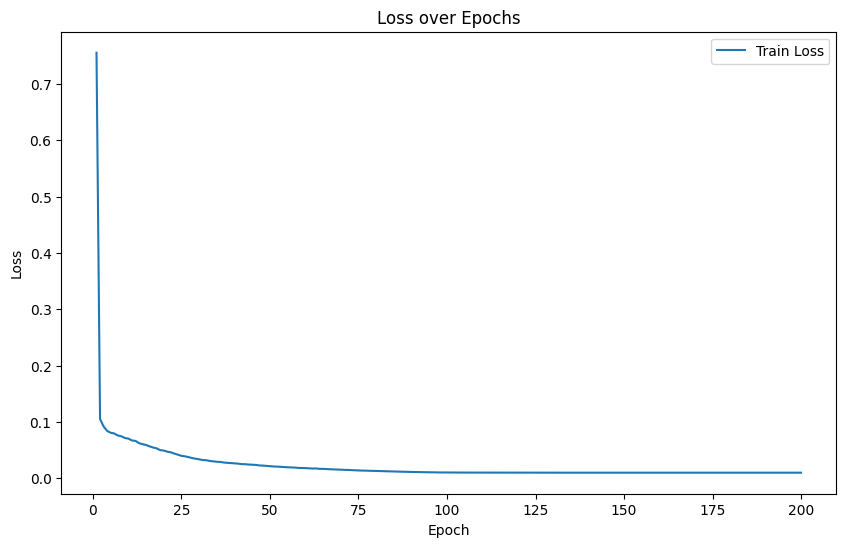

In [19]:
# Train the baseline model
input_dim = housing_data.shape[1]
baseline = HyperImpute(input_dim)
train_baseline(baseline, train_loader)

#### MAE Training

In [20]:
## MAE Model

def train_mae(train_loader, model, optimizer, criterion, device, epochs=200):
    # Initialize a list to store the average loss per epoch
    epoch_losses = []

    for epoch in range(epochs):
        epoch_start_time = time.time()
        total_loss = 0
        model.train()

        train_running_loss = []
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            reconstructed, masked_indices = model(inputs)
            # Calculate loss only on masked indices
            loss = criterion(reconstructed[:, masked_indices], inputs[:, masked_indices])
            train_running_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_running_loss)
        epoch_losses.append(train_loss)
        time_taken = round(time.time() - epoch_start_time, 1)
        print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, time_taken: {time_taken}")
    
    torch.save(model, 'trained_mae_imputation.pth')

    # Plot the training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), epoch_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

Epoch 1/200, train loss: 2.0350, time_taken: 6.5
Epoch 2/200, train loss: 1.9382, time_taken: 7.0
Epoch 3/200, train loss: 1.8835, time_taken: 8.2
Epoch 4/200, train loss: 1.9371, time_taken: 7.1
Epoch 5/200, train loss: 1.9775, time_taken: 7.2
Epoch 6/200, train loss: 1.9221, time_taken: 7.4
Epoch 7/200, train loss: 1.9015, time_taken: 10.7
Epoch 8/200, train loss: 1.9490, time_taken: 7.5
Epoch 9/200, train loss: 1.9908, time_taken: 7.9
Epoch 10/200, train loss: 1.8725, time_taken: 10.8
Epoch 11/200, train loss: 1.9996, time_taken: 10.6
Epoch 12/200, train loss: 1.9393, time_taken: 9.7
Epoch 13/200, train loss: 1.9465, time_taken: 8.5
Epoch 14/200, train loss: 1.9972, time_taken: 6.8
Epoch 15/200, train loss: 1.9894, time_taken: 6.9
Epoch 16/200, train loss: 1.9047, time_taken: 6.7
Epoch 17/200, train loss: 1.9819, time_taken: 6.8
Epoch 18/200, train loss: 1.8610, time_taken: 6.9
Epoch 19/200, train loss: 1.8981, time_taken: 7.5
Epoch 20/200, train loss: 2.0440, time_taken: 6.9
Epoch 

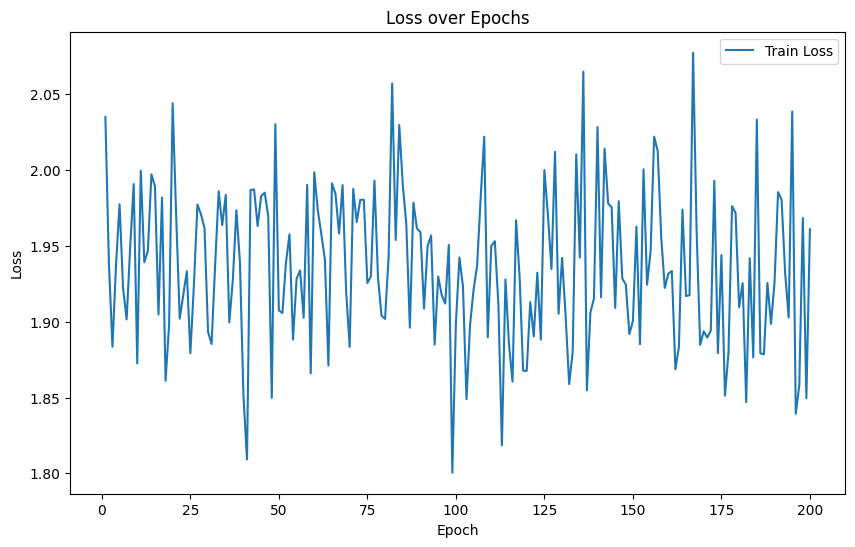

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MAETransformerModel(num_features=housing_data.shape[1], masking_ratio=0.75).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_mae(train_loader, model, optimizer, criterion, device)

## Evaluation

#### Baseline Model Evaluation

In [22]:
def evaluate_baseline(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_wasserstein_distance = 0.0
    n_batches = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_loader:
            outputs = model(inputs)
            print("targets vs outputs")
            print(targets, outputs)
            loss = criterion(outputs, targets)  # Use inputs as the target for loss calculation
            total_loss += loss.item()
            
            # Compute Wasserstein distance for each feature and average over all features
            wasserstein_distance_per_feature = [wasserstein_distance(outputs[:, i].cpu().numpy(), inputs[:, i].cpu().numpy()) 
                                                for i in range(inputs.shape[1])]
            total_wasserstein_distance += sum(wasserstein_distance_per_feature) / len(wasserstein_distance_per_feature)
            n_batches += 1
    
    average_loss = total_loss / n_batches
    avg_wasserstein_distance = total_wasserstein_distance / n_batches
    
    return average_loss, avg_wasserstein_distance


In [23]:
average_loss, avg_w_d = evaluate_baseline(torch.load('trained_baseline_imputation.pth'), test_loader, nn.MSELoss())
print(f"Average MSE Loss: {average_loss:.4f}")
print(f"Average Wasserstein Distance: {avg_w_d:.4f}")

targets vs outputs
tensor([[ 1.2456e+01, -3.4552e+00, -1.2303e-02, -5.0247e-05, -1.4851e-04,
         -8.3673e-05, -1.5760e-04, -2.1710e-02, -3.0925e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 1.2416e+01, -3.3962e+00, -1.9223e-02, -4.6727e-05, -1.2833e-04,
         -8.1472e-05, -1.3859e-04, -1.5512e-02, -3.0925e-02,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.2447e+01, -3.4424e+00, -8.0738e-03, -4.8455e-05, -1.3467e-04,
         -8.2268e-05, -1.4281e-04, -2.1521e-02, -3.0925e-02,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.2408e+01, -3.3970e+00, -8.4583e-03, -5.0054e-05, -1.4856e-04,
         -8.3530e-05, -1.5850e-04, -2.3098e-02, -3.0925e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 1.2410e+01, -3.3965e+00, -1.8454e-02, -4.9464e-05, -1.4083e-04,
         -8.3356e-05, -1.5201e-04, -1.7345e-02, -3.0925e-02,  0.000

#### MAE Evaluation

In [24]:
def evaluate_mae(model, test_loader, device):
    model.eval()
    criterion = nn.MSELoss()
    total_mse_loss = 0.0
    total_wasserstein_distance = 0.0
    count = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs, _ = model(inputs)

            # Compute MSE loss
            mse_loss = criterion(outputs, targets)
            total_mse_loss += mse_loss.item()

            # Compute Wasserstein distance for each feature and average
            batch_wasserstein_distance = 0.0
            for i in range(inputs.shape[1]):  # Iterate over each feature
                batch_wasserstein_distance += wasserstein_distance(outputs[:, i].cpu().numpy(), targets[:, i].cpu().numpy())
            batch_wasserstein_distance /= inputs.shape[1]
            total_wasserstein_distance += batch_wasserstein_distance

            count += 1

    avg_mse_loss = total_mse_loss / count
    avg_wasserstein_distance = total_wasserstein_distance / count
    print(f"Avg MSE Loss: {avg_mse_loss:.4f}, Avg Wasserstein Distance: {avg_wasserstein_distance:.4f}")

In [26]:
evaluate_mae(torch.load('trained_mae_imputation.pth'), test_loader, device)

Avg MSE Loss: 0.4325, Avg Wasserstein Distance: 0.2873
